## Import dependencies

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pathlib
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import cv2

TRAIN_PATH = pathlib.Path('./chest_xray/train/')
TEST_PATH = pathlib.Path('./chest_xray/test/')

print(tf.__version__)

2.0.0


## Number of samples

In [2]:
train_count = len(list(TRAIN_PATH.glob('*/*.jpeg')))
test_count = len(list(TEST_PATH.glob('*/*.jpeg')))
train_count, test_count

(5216, 624)

## Normal Pacient vs Pacient with Pneumonia

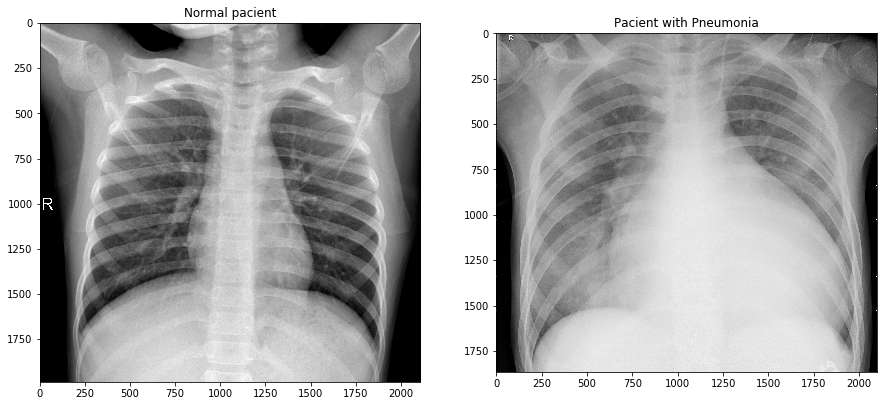

In [3]:
normal_files = list(TRAIN_PATH.glob('NORMAL/*'))
pneumonia_files = list(TRAIN_PATH.glob('PNEUMONIA/*'))

normal_img = cv2.imread(str(normal_files[2]))
pneumonia_img = cv2.imread(str(pneumonia_files[2]))

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Normal pacient')
ax2 = fig.add_subplot(222)
ax2.title.set_text('Pacient with Pneumonia')
ax1.imshow(normal_img)
ax2.imshow(pneumonia_img)

## Create dataset of the file paths

In [4]:
train_ds = tf.data.Dataset.list_files(str(TRAIN_PATH/'*/*'))

for f in train_ds.take(5):
    print(f.numpy())

b'chest_xray/train/NORMAL/NORMAL2-IM-1114-0001.jpeg'
b'chest_xray/train/PNEUMONIA/person718_virus_1316.jpeg'
b'chest_xray/train/NORMAL/NORMAL2-IM-0397-0001.jpeg'
b'chest_xray/train/NORMAL/IM-0278-0001.jpeg'
b'chest_xray/train/NORMAL/IM-0620-0001.jpeg'


In [5]:
CLASS_NAMES = np.array([item.name for item in TRAIN_PATH.glob('*')])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = train_ds.map(process_path, AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


## Label count

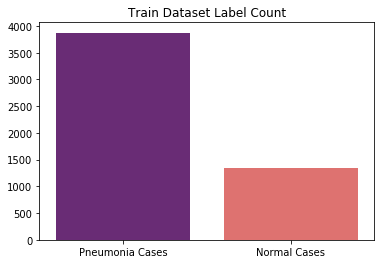

(3875, 1341)

In [21]:
import seaborn as sns

pneumonia_count = len(list(TRAIN_PATH.glob("PNEUMONIA/*")))
normal_count = len(list(TRAIN_PATH.glob("NORMAL/*")))

sns.barplot(x=['Pneumonia Cases', 'Normal Cases'], y=[pneumonia_count, normal_count], palette='magma')
plt.title('Train Dataset Label Count')
plt.show()
pneumonia_count, normal_count

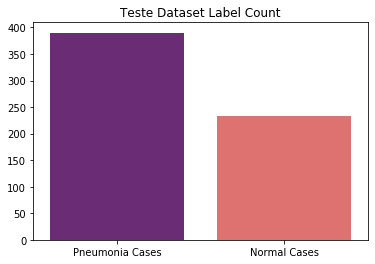

(390, 234)

In [22]:
test_pneumonia_count = len(list(TEST_PATH.glob("PNEUMONIA/*")))
test_normal_count = len(list(TEST_PATH.glob("NORMAL/*")))

sns.barplot(x=['Pneumonia Cases', 'Normal Cases'], y=[test_pneumonia_count, test_normal_count], palette='magma')
plt.title('Teste Dataset Label Count')
plt.show()
test_pneumonia_count, test_normal_count

In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [11]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

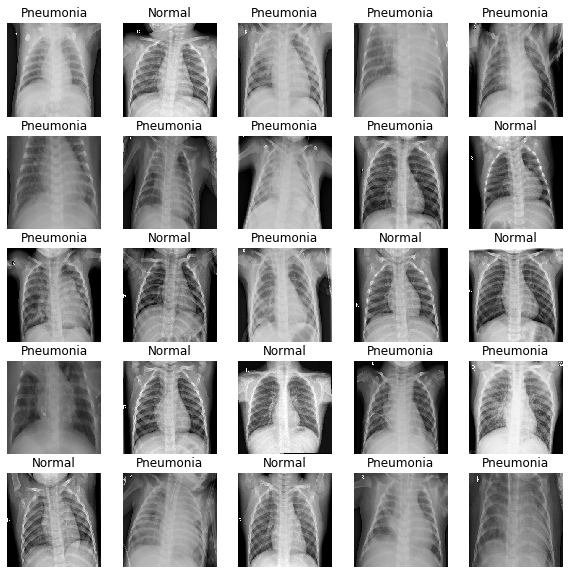

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Data generators

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [28]:
test_data_generator = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=TEST_PATH,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='binary')

train_data_generator = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=TRAIN_PATH,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [31]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
total_train = pneumonia_count + normal_count
total_test = test_pneumonia_count + test_normal_count

history = model.fit_generator(
    train_data_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_generator,
    validation_steps=total_test // batch_size
)

Epoch 1/15
15/40 [==========>...................] - ETA: 53s - loss: 0.7150 - accuracy: 0.6771

KeyboardInterrupt: 